### 統計學習與深度學習
### Homework 3
R08725033 資管碩二 陳柏勳

### 第一題 [分類器、特徵建構、與Stacking]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

OrderedDict([('gname', '承憲'), ('sex', '1'), ('fold', '9')])
OrderedDict([('gname', '均平'), ('sex', '1'), ('fold', '7')])
OrderedDict([('gname', '思安'), ('sex', '0'), ('fold', '6')])
OrderedDict([('gname', '佑誠'), ('sex', '1'), ('fold', '3')])
OrderedDict([('gname', '乃馨'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '婕'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '冠瑜'), ('sex', '0'), ('fold', '1')])
OrderedDict([('gname', '冠學'), ('sex', '1'), ('fold', '0')])
OrderedDict([('gname', '立翰'), ('sex', '1'), ('fold', '2')])
OrderedDict([('gname', '以柔'), ('sex', '0'), ('fold', '6')])


In [2]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

資料筆數 =  10730


In [3]:
avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

男性比率 0.47940354147250697


In [4]:
import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名字:")
sex_tend.head(20)

最常見的20個名字:


name-  sex-mean  sex-count
3738    承恩  1.000000         20
918     冠廷  1.000000         20
2506    宜蓁  0.000000         18
545     佳穎  0.000000         16
3196    彥廷  0.923077         13
913     冠宇  1.000000         13
3390    思妤  0.000000         13
1019    凱翔  1.000000         13
3769    承翰  1.000000         13
3477    怡萱  0.000000         13
497     佳妤  0.000000         12
4683    柏翰  1.000000         12
2114    子瑜  0.090909         11
4907    欣妤  0.000000         11
1351    品妤  0.000000         10
7889    鈺婷  0.000000         10
2499    宜臻  0.000000          9
1441    哲瑋  1.000000          9
7024    芳瑜  0.000000          9
2140    子芸  0.000000          9

In [5]:
single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

出現一次名子個數:  7067 比率: 0.6586206896551724


In [6]:
ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

難區分性別姓名數量:  136 比率: 0.012674743709226468


In [7]:
sex_amb.head()

name-  sex-mean  sex-count
6777    育瑋       0.5          4
338     以恩       0.5          4
7783    郁軒       0.5          4
2513    宜謙       0.5          4
5920    祐嘉       0.5          4

#### Q1.1 (10%): 
* 首先使用loc依照fold取出分屬於四個set的index。
* 使用dictionary的結構進行one-hot encoding，feature出現一次先放入list，出現第二次再加入dictionary，並給予index（第幾個feature）。
* 判斷name的長度，避免單名重複處理。  
* 接著再讀取一次名字列表，若在dictionary中找到，則將對應的feature（`row_i[feature_index]`）改為1。
* 若找不到，最後一欄（_Other_Feature_）+= 1。

In [8]:
train_index = name_df.loc[name_df['fold']<=6].index
valid_index = name_df.loc[name_df['fold']==7].index
stack_index = name_df.loc[name_df['fold']==8].index
test_index = name_df.loc[name_df['fold']==9].index

In [9]:
# Build dictionary
one_time = []
name_d = {}
index = 0

for n in name_df['name'][train_index]: # Use train data to encode
    # Whole name
    if name_d.get(n) == None:
        if n in one_time: # Add to dictionary
            name_d[n] = index
            index += 1
        else:
            one_time.append(n)
    
    # For each charater
    if len(n) > 1:
        for w in n:
            if name_d.get(w) == None:
                if w in one_time:
                    name_d[w] = index
                    index += 1
                else:
                    one_time.append(w)
                
# name_d['_Other_Feature_'] = index

In [10]:
feature = [0]*(len(name_d)+1) # Add '_Other_Feature_'
features = [feature]*len(name_df['name'])
features = np.array(features)

In [11]:
# Generate feature array
for i in range(len(name_df['name'])):
    # Whole name
    n = name_df['name'][i]
    if name_d.get(n) == None:
        features[i][-1] += 1
    else:
        features[i][name_d.get(n)] += 1
    
    # For each charater
    if len(n) > 1:
        for w in n:
            if name_d.get(w) == None:
                features[i][-1] += 1
            else:
                features[i][name_d.get(w)] += 1

In [12]:
x_train = features[train_index]
y_train = np.array(name_df['sex'][train_index])

x_valid = features[valid_index]
y_valid = np.array(name_df['sex'][valid_index])

x_stack = features[stack_index]
y_stack = np.array(name_df['sex'][stack_index])

x_test = features[test_index]
y_test = np.array(name_df['sex'][test_index])

print('x_train shape =', x_train.shape)
print('y_train shape =', y_train.shape)
print('x_valid shape =', x_valid.shape)
print('y_valid shape =', y_valid.shape)
print('x_stack shape =', x_stack.shape)
print('y_stack shape =', y_stack.shape)
print('x_test shape =', x_test.shape)
print('y_test shape =', y_test.shape)

x_train shape = (7483, 1630)
y_train shape = (7483,)
x_valid shape = (1110, 1630)
y_valid shape = (1110,)
x_stack shape = (1073, 1630)
y_stack shape = (1073,)
x_test shape = (1064, 1630)
y_test shape = (1064,)


x, y各4個set的shape與老師提供的資料相同。

#### Q1.2 (10%):
* 首先建立10^-4~10^3, 20 Points的grid。
* 接著分別跑max_iter為1000的logistic regression（max_iter不夠大c大的會不收斂），選出F1-Score最高的best c。
* 合併train和valid，建模並印出統計量。
* 使用abs()的coef進行排序，並印出重要特徵的內容，以及原序列中的coef。

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# Generate Regularization Coefficient Grid
c_grid = np.logspace(-4, 3, 20, endpoint=True, base=10) # 10**-4 ~ 10**3, 20 points

bestc = c_grid[0]
best_f1 = float("-inf")
for c in c_grid:
    clf = LogisticRegression(C=c, random_state=0, max_iter=1000).fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred, average='binary')
    if f1 > best_f1:
        bestc = c
        best_f1 = f1
print("The bestc is:", bestc, "which has F-1 Score =", best_f1)

The bestc is: 78.47599703514607 which has F-1 Score = 0.8983050847457626


In [13]:
x_trainAll = np.concatenate((x_train, x_valid))
y_trainAll = np.concatenate((y_train, y_valid))

In [22]:
clf_l = LogisticRegression(C=bestc, random_state=0, max_iter=1000).fit(x_trainAll, y_trainAll)
y_pred = clf_l.predict(x_test)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('Accuracy =', accuracy_score(y_test, y_pred))
print('Precision =', precision_score(y_test, y_pred, average='binary'))
print('Recall =', recall_score(y_test, y_pred, average='binary'))
print('F-1 Score =', f1_score(y_test, y_pred, average='binary'))

Accuracy = 0.8843984962406015
Precision = 0.8596837944664032
Recall = 0.893223819301848
F-1 Score = 0.8761329305135951


In [17]:
absCoef = abs(clf_l.coef_[0])
maxCoef = absCoef.argsort()[-20:]

In [18]:
for m in maxCoef:
    try:
        print(list(name_d.keys())[m], clf_l.coef_[0][m])
    except:
        print('_Other_Feature_', clf_l.coef_[0][m])

蓉 -7.592862496567295
松 7.598024699667111
靜 -7.665150706350064
卉 -7.823645965306096
絃 -7.865039826781008
嵐 -7.873388663923237
潔 -8.05536219172011
綾 -8.141578390030162
婕 -8.16768555189859
妤 -8.18312885636064
鋒 8.204445596708787
薇 -8.23321590772957
萱 -8.303343726456795
美 -8.333116637287576
婷 -8.413307648411108
凌 -8.464360516926398
雯 -8.498336305351394
玲 -8.65857364951307
森 8.681890364106875
傑 9.25260191398911


最好的C為78.476，模型表現如上。最重要的Feature都很合理，正的像生理男，負的像生理女會使用的名字。

#### Q1.3 (10%):
* 首先建立5~1000, 10個整數Points的grid。
* 接著分別跑Random Forest Classifier（Max_depth不設限），選出F1-Score最高的best_nest。
* 使用abs()的feature importance進行排序，並印出重要特徵的內容，以及原序列中的feature importance。

In [20]:
from sklearn.ensemble import RandomForestClassifier
t_grid = []
d = np.power(1000/5, 1/9)
for i in range(10):
    t_grid.append(5*np.power(d,i)) # 5~1000, 10 points
t_grid = list(map(int, t_grid)) # number of tree must be integer
t_grid[-1] = 1000

In [20]:
best_nest = t_grid[0]
best_f1 = float("-inf")
for t in t_grid:
    clf = RandomForestClassifier(n_estimators=t, random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    f1 = f1_score(y_valid, y_pred, average='binary')
    if f1 > best_f1:
        best_nest = t
        best_f1 = f1
print("The best_nest is:", best_nest, "which has F-1 Score =", best_f1)

The best_nest is: 1000 which has F-1 Score = 0.8813559322033898


In [23]:
clf_r = RandomForestClassifier(n_estimators=best_nest, random_state=0).fit(x_trainAll, y_trainAll)
y_pred = clf_r.predict(x_test)
print('Accuracy =', accuracy_score(y_test, y_pred))
print('Precision =', precision_score(y_test, y_pred, average='binary'))
print('Recall =', recall_score(y_test, y_pred, average='binary'))
print('F-1 Score =', f1_score(y_test, y_pred, average='binary'))

Accuracy = 0.8524436090225563
Precision = 0.8136882129277566
Recall = 0.8788501026694046
F-1 Score = 0.8450148075024679


In [24]:
absFeat = abs(clf_r.feature_importances_)
maxFeat = absFeat.argsort()[-20:]
for m in maxFeat:
    try:
        print(list(name_d.keys())[m], clf_r.feature_importances_[m])
    except:
        print('_Other_Feature_', clf_r.feature_importances_[m])

瑄 0.007745687559795083
涵 0.007841293271731782
庭 0.007919662084977254
宜 0.007979711268124495
芸 0.008152476902246417
晴 0.008273409541733138
芷 0.008278643163864919
柔 0.008281339902834814
佳 0.008484781791337217
承 0.008629068172498498
雅 0.008690165370377022
蓁 0.00888129846432
哲 0.008895063453767067
怡 0.009438489268114148
婷 0.01277220172674787
柏 0.013154652912927315
萱 0.014158706199023608
翔 0.014973146396627016
_Other_Feature_ 0.016589767426530542
妤 0.018785990784009443


最好的Tree為1000（大於投影片推薦的根號1630），模型表現如上，相比logistic regression來得較差。雖然feature_importances_沒有+, -協助辨別男女，但最重要的Feature都有生理男或女的傾向。然而單一的重要性都不如LogisticRegression，可能是導致_Other_Featrue_第二重要的原因。

#### Q1.4 (10%):

* 首先建立0.1, 0.5和1的lr grid。
* 接著分別跑Gradient Boosting Classifier，印出三種lr下F1-Score和nstg的關係，選出F1-Score最高的best_lr和其對應的best_nstg。
* 使用abs()的feature importance進行排序，並印出重要特徵的內容，以及原序列中的feature importance。

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
lr=[0.1, 0.5, 1]

clf = GradientBoostingClassifier(learning_rate=lr[0], n_estimators=1500, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.staged_predict(x_valid)
y_pred = list(y_pred)

stage = list(range(1,1500))
f1_list = []
for i in stage:
    f1_list.append(f1_score(y_valid, y_pred[i], average='binary'))
    
best_nstg = np.argmax(f1_list)
f1 = f1_list[best_nstg]
print('Best nstg =', best_nstg, ',which has F-1 Score =', f1)

Best nstg = 1450 ,which has F-1 Score = 0.9029850746268657


Text(0, 0.5, 'F-1 Score')

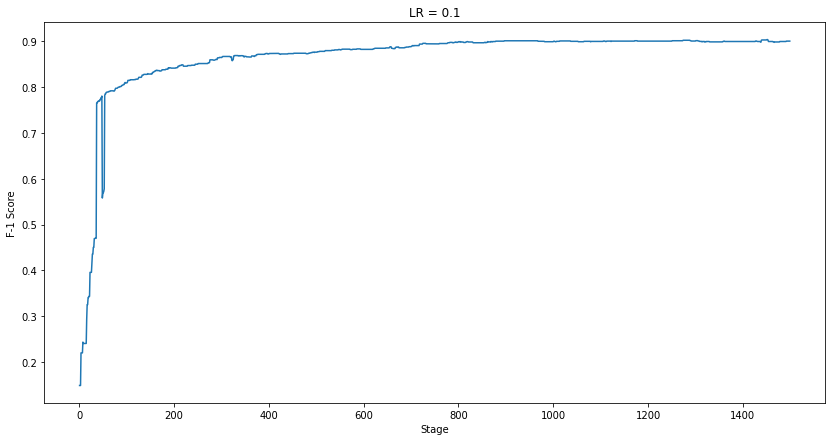

In [34]:
plt.figure(figsize=(14, 7))
plt.title('LR = 0.1')
plt.plot(stage, f1_list)
plt.xlabel('Stage')
plt.ylabel('F-1 Score')

In [35]:
clf = GradientBoostingClassifier(learning_rate=lr[1], n_estimators=1500, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.staged_predict(x_valid)
y_pred = list(y_pred)

stage = list(range(1,1500))
f1_list = []
for i in stage:
    f1_list.append(f1_score(y_valid, y_pred[i], average='binary'))
    
best_nstg = np.argmax(f1_list)
f1 = f1_list[best_nstg]
print('Best nstg =', best_nstg, ',which has F-1 Score =', f1)

Best nstg = 316 ,which has F-1 Score = 0.9028037383177568


Text(0, 0.5, 'F-1 Score')

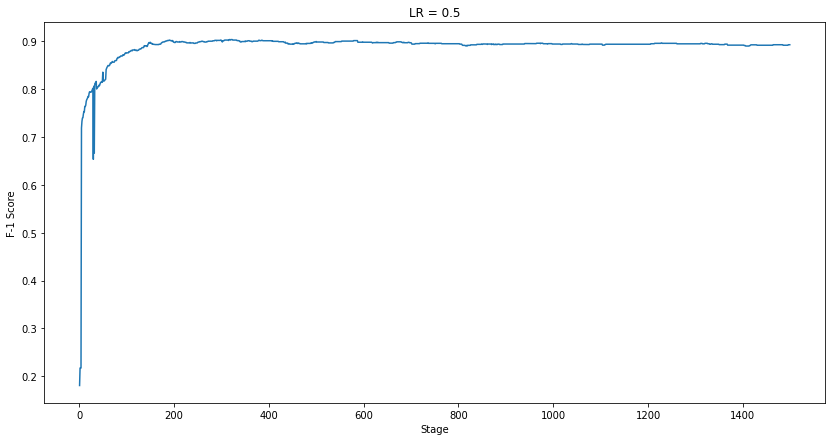

In [36]:
plt.figure(figsize=(14, 7))
plt.title('LR = 0.5')
plt.plot(stage, f1_list)
plt.xlabel('Stage')
plt.ylabel('F-1 Score')

In [19]:
clf = GradientBoostingClassifier(learning_rate=lr[2], n_estimators=1500, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.staged_predict(x_valid)
y_pred = list(y_pred)

stage = list(range(1,1500))
f1_list = []
for i in stage:
    f1_list.append(f1_score(y_valid, y_pred[i], average='binary'))
    
best_nstg = np.argmax(f1_list)
f1 = f1_list[best_nstg]
print('Best nstg =', best_nstg, ',which has F-1 Score =', f1)

Best nstg = 464 ,which has F-1 Score = 0.8985781990521328


Text(0, 0.5, 'F-1 Score')

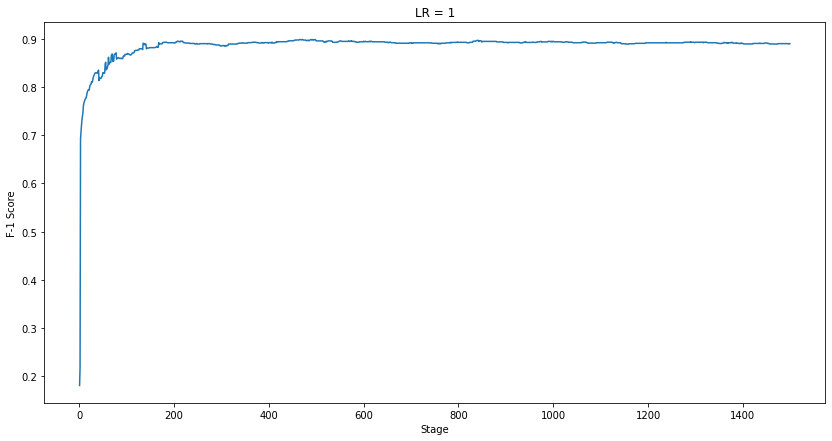

In [22]:
plt.figure(figsize=(14, 7))
plt.title('LR = 1')
plt.plot(stage, f1_list)
plt.xlabel('Stage')
plt.ylabel('F-1 Score')

In [25]:
# Best parameter: lr = 0.1, nstg = 1450
clf_g = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1450, random_state=0)
clf_g.fit(x_trainAll, y_trainAll)
y_pred = clf_g.predict(x_test)
print('Accuracy =', accuracy_score(y_test, y_pred))
print('Precision =', precision_score(y_test, y_pred, average='binary'))
print('Recall =', recall_score(y_test, y_pred, average='binary'))
print('F-1 Score =', f1_score(y_test, y_pred, average='binary'))

Accuracy = 0.8731203007518797
Precision = 0.8371647509578544
Recall = 0.8973305954825462
F-1 Score = 0.8662041625371655


In [26]:
absFeat = abs(clf_g.feature_importances_)
maxFeat = absFeat.argsort()[-20:]
for m in maxFeat:
    try:
        print(list(name_d.keys())[m], clf_g.feature_importances_[m])
    except:
        print('_Other_Feature_', clf_g.feature_importances_[m])

庭 0.009575193374732146
慈 0.009622511548342347
瑄 0.010008565583929466
芷 0.010091808965027363
涵 0.010375472732126871
芸 0.010526591134052944
佳 0.010763282956768554
柔 0.010936503863838591
宜 0.011018623360715445
晴 0.011195661386036346
雅 0.011394107712556162
蓁 0.012004568433467493
哲 0.012186919584674554
承 0.012190474956233002
怡 0.012307906141706312
婷 0.01799131421585365
柏 0.01879238768492655
萱 0.0191130593893972
翔 0.02163249862628457
妤 0.028438073291609505


Gradient Boosting Classifier的模型表現如上，在Test data的表現略優於Random Forest，差於Logistic Regression。重要的Feature基本上都有生理男、女的傾向，在模型中的importance略高於Random Forest。值得注意的是兩者之間相當相似（庭、萱、芷，哲、柏、翔…等等），然後三個模型選出來的重要feature都是單字，而非名字。

#### Q1.5 (10%):
* 結合原本三個模型預測x_stack為男生（1）的機率，產生出新的特徵向量proba。
* 使用proba和y_stack fit penalty="none"的Logistic Regression模型。
* 透過x_test產生test proba，進行預測。

In [23]:
y_logis = clf_l.predict_proba(x_stack)
y_random = clf_r.predict_proba(x_stack)
y_gradient = clf_g.predict_proba(x_stack)

proba = np.vstack((y_logis[:,1], y_random[:,1]))
proba = np.vstack((proba, y_gradient[:,1]))
proba = proba.T

In [57]:
clf_s = LogisticRegression(penalty='none', random_state=0).fit(proba, y_stack)
clf_s.coef_

array([[ 2.77373274, -1.17918189,  6.20291401]])

In [55]:
y_logis_t = clf_l.predict_proba(x_test)
y_random_t = clf_r.predict_proba(x_test)
y_gradient_t = clf_g.predict_proba(x_test)

proba_t = np.vstack((y_logis_t[:,1], y_random_t[:,1]))
proba_t = np.vstack((proba_t, y_gradient_t[:,1]))
proba_t = proba_t.T

y_pred = clf_s.predict(proba_t)

print('Accuracy =', accuracy_score(y_test, y_pred))
print('Precision =', precision_score(y_test, y_pred, average='binary'))
print('Recall =', recall_score(y_test, y_pred, average='binary'))
print('F-1 Score =', f1_score(y_test, y_pred, average='binary'))

Accuracy = 0.8862781954887218
Precision = 0.860236220472441
Recall = 0.8973305954825462
F-1 Score = 0.878391959798995


* 三個模型的係數分別為，2.77, -1.18, 6.20，代表在stack資料中，Gradient的預測能力>Logistic>Random Forest。
* Random Forest甚至很有可能常常分錯，才被給予負的係數。
* 對於test data的表現，stack模型都有比原本最好的Logistic模型成長了千分之幾的成績，證明stacking對於三個模型處理這個資料集的能力，真的能各取所長。

## 第二題 [Data Visualization via Dimensionality Reduction]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("There are %d students and %d departments in total." % (nstuid, ndepid))

print("offers received by students:")
stu_adm.head(10)

There are 60461 students and 1976 departments in total.
offers received by students:


school_id department_id student_id student_name state location1 location2
0       001        001012   10246842          黃士玹    正1        南部      台南考區
1       001        001012   10042237          黃冠婷    正2        北部      台北考區
2       001        001012   10008031          鍾大方    正3        北部      台北考區
3       001        001012   10201525          曾信豪    正4        中部      彰化考區
4       001        001012   10014615          陳品儒    正5        北部      台北考區
5       001        001012   10294018          侯思筠    正6        東部      宜蘭考區
6       001        001012   10022810          吳悅慈    正7        北部      台北考區
7       001        001012   10236223          陳俞潔    正8        南部      台南考區
8       001        001012   10025909          蕭宇廷    正9        北部      台北考區
9       001        001012   10123708          吳岱軒   正10        北部      中壢考區

In [2]:
print("academic department basic information:")
uname.head(10)

academic department basic information:


year school_id department_id school_name department_name category_id  \
0  106       006        006042      國立政治大學            教育學系           1   
1  106       006        006052      國立政治大學       教育學系(公費生)           1   
2  106       006        006062      國立政治大學    教育學系(原住民公費生)           1   
3  106       006        006022      國立政治大學            歷史學系           2   
4  106       006        006152      國立政治大學            民族學系           2   
5  106       006        006032      國立政治大學             哲學系           2   
6  106       006        006262      國立政治大學          英國語文學系           2   
7  106       006        006292      國立政治大學          日本語文學系           2   
8  106       006        006272      國立政治大學         阿拉伯語文學系           2   
9  106       006        006302      國立政治大學          韓國語文學系           2   

  category_name school_name_abbr department_name_abbr  
0            教育               政大                   教育  
1            教育               政大                教育(公)  
2            教育               政大              教育(原住民)  
3         藝術及人文               政大                   歷史  
4         藝術及人文               政大                  民族學  
5         藝術及人文               政大                   哲學  
6         藝術及人文               政大                 英國語文  
7         藝術及人文               政大                 日本語文  
8         藝術及人文               政大                阿拉伯語文  
9         藝術及人文               政大                 韓國語文

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

all_depid = stu_adm['department_id'].unique()
all_stuid = stu_adm['student_id'].unique()

ndepid = all_depid.shape[0]
nstuid = all_stuid.shape[0]
print("In raw data, there are %d students and %d departments in total." % (nstuid, ndepid))

#construct the department-student matrix (i.e. array). 
dep_stu = np.zeros((ndepid, nstuid))
rowname = all_depid.copy()

depid_seq_map = dict()
for i in range(ndepid):
    depid_seq_map[all_depid[i]] = i

stuid_seq_map = dict()
for i in range(nstuid):
    stuid_seq_map[all_stuid[i]] = i

for cindex, row in stu_adm.iterrows():
    #print(cindex, row)
    dep_seq = depid_seq_map[row['department_id']]
    stu_seq = stuid_seq_map[row['student_id']]
    #print(dep_seq, stu_seq)
    dep_stu[dep_seq, stu_seq] = 1

#Remove very small departments.
min_stu_per_dep = 10
min_apply_dep_per_stu = 2

#remove small departments and single-application students. 
dep_apply_sum = np.sum(dep_stu, axis = 1)
keeprow = dep_apply_sum >= min_stu_per_dep
rowname = rowname[keeprow]
dep_stu2 = dep_stu[keeprow,:]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#another run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]
stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#third run of filtering
dep_apply_sum = np.sum(dep_stu2, axis = 1)
dep_stu2 = dep_stu2[dep_apply_sum >= min_stu_per_dep,:]
rowname = rowname[dep_apply_sum >= min_stu_per_dep]

stu_apply_sum = np.sum(dep_stu2, axis = 0)
dep_stu2 = dep_stu2[:, stu_apply_sum >= min_apply_dep_per_stu]

#check to make sure the two conditions are satisfied. 
dep_apply_sum = np.sum(dep_stu2, axis = 1)
print("Number of department too small:", np.sum(dep_apply_sum < min_stu_per_dep))
stu_apply_sum = np.sum(dep_stu2, axis = 0)
print("Number of students applying only one department:", np.sum(stu_apply_sum <min_apply_dep_per_stu))

#now both conditions are satisfied.

In raw data, there are 60461 students and 1976 departments in total.
Number of department too small: 0
Number of students applying only one department: 0


In [2]:
num_dep, num_stu = dep_stu2.shape
print("In final dataset, there are", num_dep, "academic departments and", num_stu, "student applicants.")

In final dataset, there are 1917 academic departments and 47386 student applicants.


In [3]:
uname['depname'] = uname.school_name_abbr + uname.department_name_abbr
uname2 = uname[['department_id', 'depname', 'category_name']].copy()
#this is for later use, to color data points. 
category_id, category_levels = pd.factorize(uname2.category_name)
#uname2['category_id'] = category_id / np.max(category_id)
uname2['category_id'] = category_id

#create a data frame for column name
colname_df = pd.DataFrame({'department_id': rowname})
colname_df = colname_df.merge(uname2, how = "left", on="department_id")

In [4]:
topdepid = np.argsort(dep_apply_sum)[::-1]
topn = 10
topdep = pd.DataFrame({'department_id': rowname[topdepid[0:topn]], 
                       'department_name': colname_df.depname.values[topdepid[0:topn]],
                       'num_applicant': dep_apply_sum[topdepid[0:topn]]
                       }) 
topdep

department_id department_name  num_applicant
0        008122         中原機械工程學          386.0
1        012052            中醫藥學          376.0
2        046032        銘傳會計（臺北）          367.0
3        004382            成大電機          357.0
4        005192          東吳企業管理          353.0
5        008112            中原土木          353.0
6        005182            東吳會計          351.0
7        015342            逢甲財金          340.0
8        045012            義守電機          339.0
9        046162      銘傳應用英語（桃園）          329.0

#### Q2.1 (10%): 
Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories. 
* 對data進行n_components=8的pca
* x=0123, y=7654，觀察pca之間的pattern

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
colname_df

department_id  depname category_name  category_id
0           001012     臺大中文         藝術及人文            1
1           001022     臺大外文         藝術及人文            1
2           001032     臺大歷史         藝術及人文            1
3           001042     臺大哲學         藝術及人文            1
4           001052   臺大人類學系         藝術及人文            1
...            ...      ...           ...          ...
1912        150122     宜蘭園藝   農業、林業、漁業及獸醫            9
1913        150132     宜蘭電機      工程、製造及營建            6
1914        150142   宜蘭電子工程      工程、製造及營建            6
1915        151012  聯合機械工程學      工程、製造及營建            6
1916        151022     聯合化工      工程、製造及營建            6

[1917 rows x 4 columns]

In [9]:
colname_df.columns

Index(['department_id', 'depname', 'category_name', 'category_id'], dtype='object')

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
dep_stu_pca = pca.fit_transform(dep_stu2)
dep_stu_pca=pd.DataFrame(dep_stu_pca)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

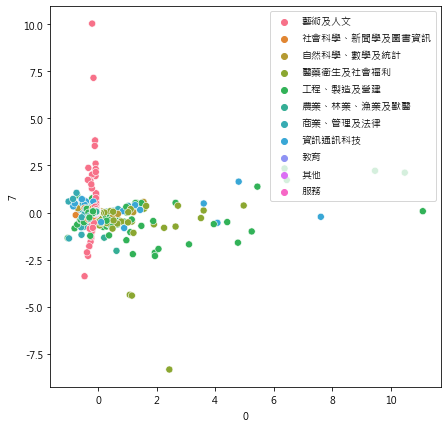

In [26]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[7], data=dep_stu_pca, hue='category_name', s=50)
plt.legend(loc='upper right')

對於PCA 0和7，「藝術及人文」和「醫藥衛生及社會福利」較明顯有自己的pattern。「工程、製造及營建」也有但沒那麼明顯。

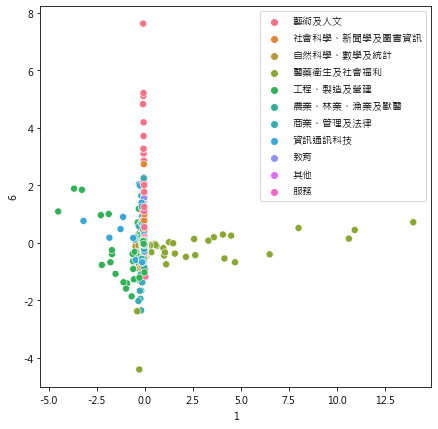

In [27]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=dep_stu_pca[1], y=dep_stu_pca[6], data=dep_stu_pca, hue='category_name', s=50)
plt.legend(loc='upper right')

對於PCA 1和6，「藝術及人文」、「醫藥衛生及社會福利」和「工程、製造及營建」較明顯有自己的pattern。

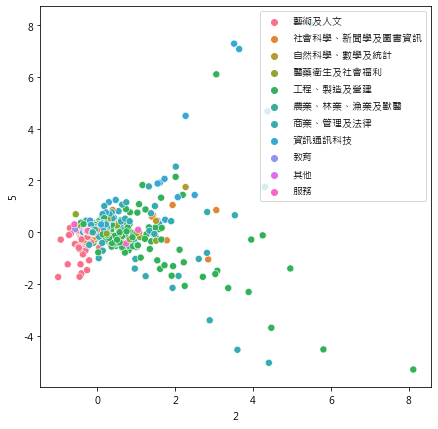

In [17]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=dep_stu_pca[2], y=dep_stu_pca[5], data=dep_stu_pca, hue='category_name', s=50)
plt.legend(loc='upper right')

對於PCA 2和5，「藝術及人文」、「工程、製造及營建」和「商業、管理及法律」較明顯有自己的pattern。

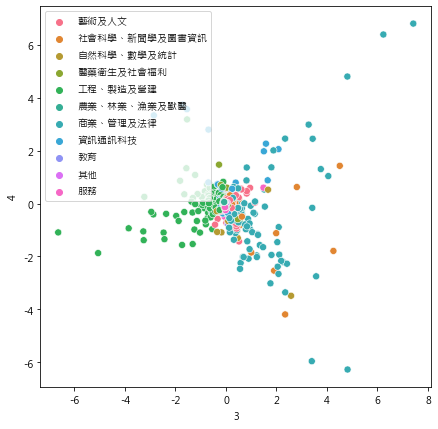

In [22]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x=dep_stu_pca[3], y=dep_stu_pca[4], data=dep_stu_pca, hue='category_name', s=50)
plt.legend(loc='upper left')

對於PCA 3和4，「工程、製造及營建」和「商業、管理及法律」較明顯有自己的pattern。  
總結以上，在這八個PCA中，「藝術及人文」、「醫藥衛生及社會福利」、「工程、製造及營建」和「商業、管理及法律」較明顯有pattern存在。

#### Q2.2 (10%): 
Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 
* 使用sklearn.manifold分別進行metric=True和False的embedding，並將結果以二維點出。

In [6]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(dep_stu2)

dep_stu_pca = pd.DataFrame(X_transformed)
dep_stu_pca = pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

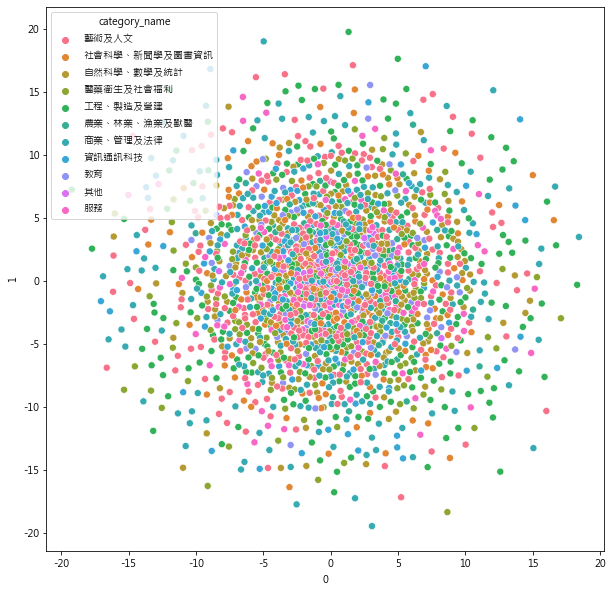

In [11]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

In [12]:
embedding = MDS(n_components=2, metric=False)
X_transformed = embedding.fit_transform(dep_stu2)

dep_stu_pca = pd.DataFrame(X_transformed)
dep_stu_pca = pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

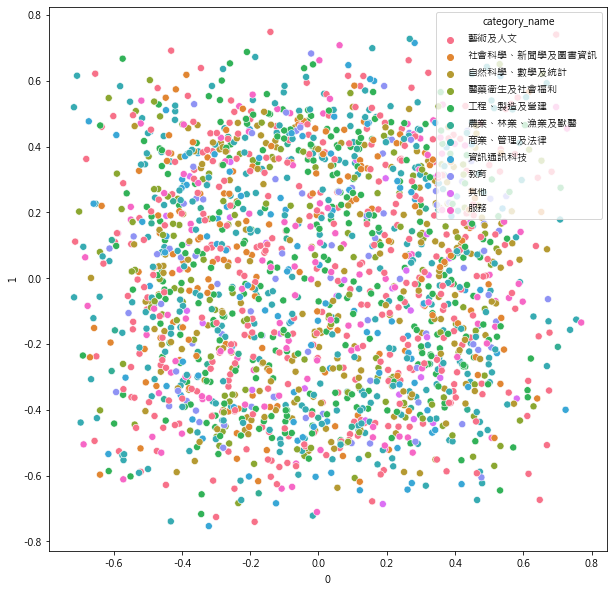

In [15]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

* 經過metric MDS的處理，所有類別的資料點看不出類別的在中間擠成一團並放射出去，代表使用原始相似性（距離）的實際數值效果並不好。  
* 然而non-metric MDS的資料點只是比較分散，依然看不出任何明顯的規律。

#### Q2.3 (10%): 
Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result. 
* 使用sklearn.manifold，按所指定的參數一一降維。

In [6]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
X_transformed = embedding.fit_transform(dep_stu2)

X_transformed = pd.DataFrame(X_transformed)
X_transformed = pd.concat([X_transformed, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

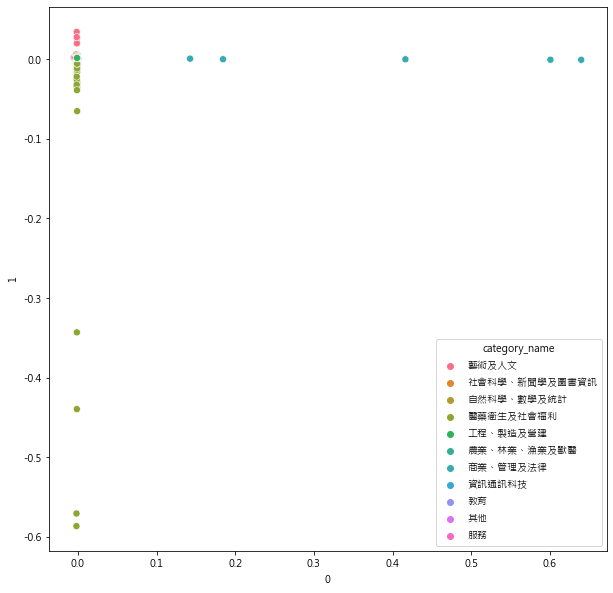

In [7]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_transformed[0], y=X_transformed[1], data=X_transformed, hue='category_name', s=50)

* 8G Ram跑case 1和case 2的時候爆Ram，故改跑neighbors=10和15。
* 除了「藝術及人文」、「醫藥衛生及社會福利」和「商業、管理及法律」，其他都嚴重重疊。

In [8]:
embedding = LocallyLinearEmbedding(n_neighbors=15, n_components=2)
X_transformed = embedding.fit_transform(dep_stu2)

X_transformed = pd.DataFrame(X_transformed)
X_transformed = pd.concat([X_transformed, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

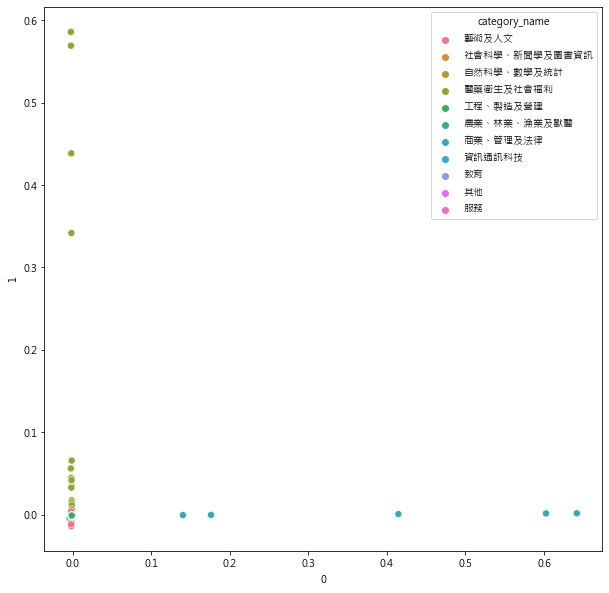

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_transformed[0], y=X_transformed[1], data=X_transformed, hue='category_name', s=50)

* 除了「藝術及人文」、「醫藥衛生及社會福利」和「商業、管理及法律」，其他都嚴重重疊。
* 藝術與人文變得更加收斂，

In [20]:
pca = PCA(n_components=100)
dep_stu_pca = pca.fit_transform(dep_stu2)

embedding = LocallyLinearEmbedding(n_neighbors=20, n_components=2)
dep_stu_pca = embedding.fit_transform(dep_stu_pca)

dep_stu_pca=pd.DataFrame(dep_stu_pca)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

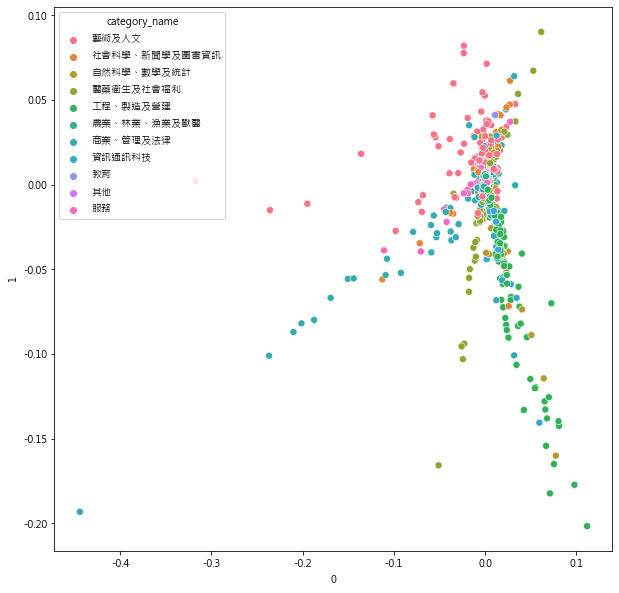

In [21]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

* 在case 3中，對100個PCA使用他們的鄰居進行降維，「藝術及人文」、「醫藥衛生及社會福利」、「工程、製造及營建」和「商業、管理及法律」較明顯有pattern存在。

#### Q2.4 (10%): 
Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result. 
* 使用sklearn.decomposition，分別使用RBF和cosine kernel進行降維。

In [7]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel="rbf", n_components=2)
dep_stu_pca = kpca.fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(dep_stu_pca)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

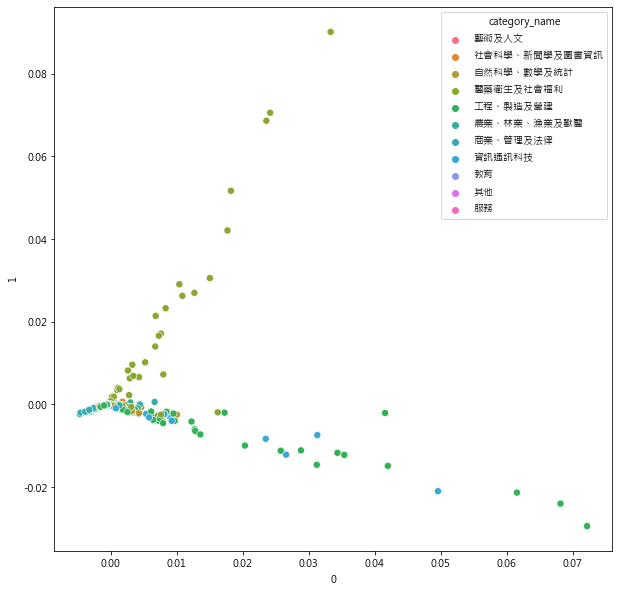

In [8]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

透過RBF函數，「醫藥衛生及社會福利」、「工程、製造及營建」和「資訊通訊科技」較明顯有pattern存在。

In [9]:
kpca = KernelPCA(kernel="cosine", n_components=2)
dep_stu_pca = kpca.fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(dep_stu_pca)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

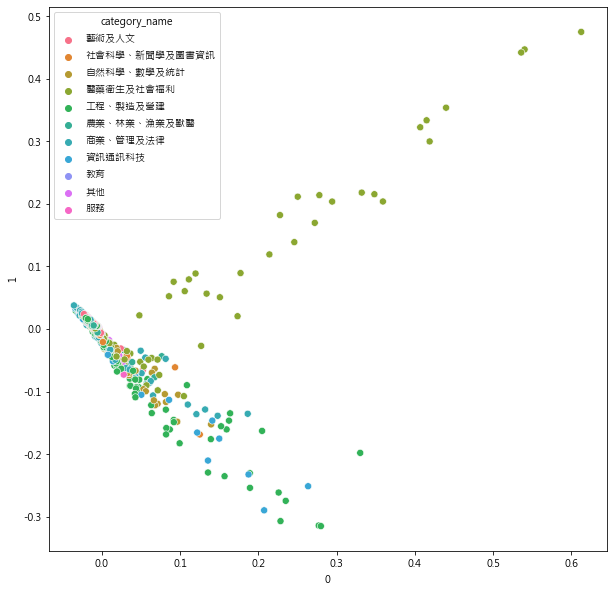

In [10]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

cosine和RBF的結果很像，「醫藥衛生及社會福利」、「工程、製造及營建」和「資訊通訊科技」較明顯有pattern存在。值得注意的是後兩者和其他人的重疊性變高。

#### Q2.5 (10%): 
Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result. 
* 使用sklearn.manifold，並分別對三個距離衡量方法進行降維。

In [9]:
from sklearn.manifold import TSNE

np.random.seed(33)

X_embedded = TSNE(n_components=2, random_state=0).fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(X_embedded)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

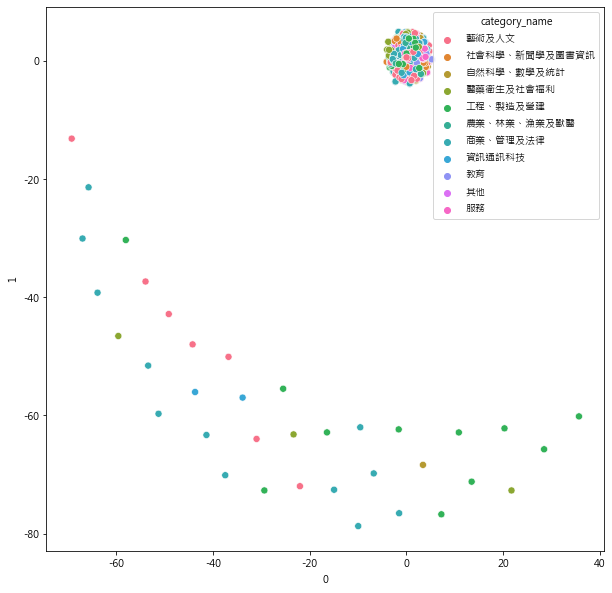

In [10]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

大部分的資料點全都聚集在一起，邊緣人的數量並不多。因此即使其中有幾類明顯較多，也沒有明確的意義。

In [11]:
np.random.seed(33)

X_embedded = TSNE(n_components=2, metric='cosine', random_state=0).fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(X_embedded)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

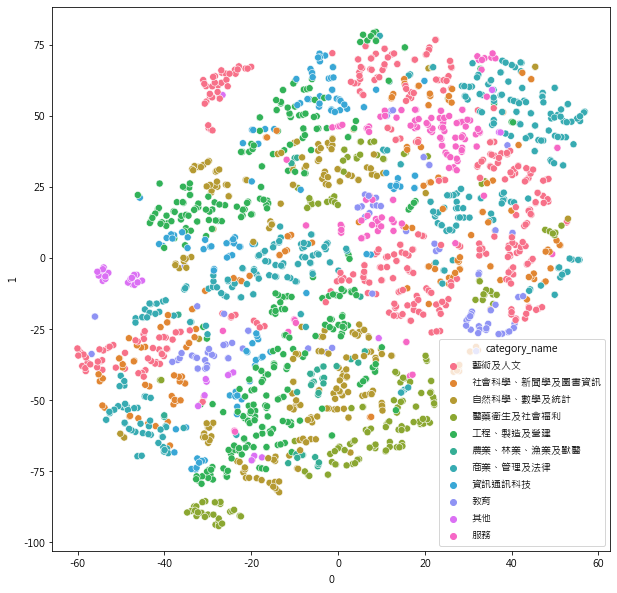

In [12]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

* 使用cosine沒有明顯的規律，但值得注意的是相較於non-metric MDS，在分散之餘cosine的左鄰右舍幾乎都是同類別的資料點。（有一塊一塊的顏色）
* 另外藝術及人文、商業等傳統上文組的點較接近，自然、醫藥與工程等傳統上理組的點較接近。

In [13]:
np.random.seed(33)

X_embedded = TSNE(n_components=2, metric='jaccard', random_state=0).fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(X_embedded)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df['category_name']], axis=1)

<AxesSubplot:xlabel='0', ylabel='1'>

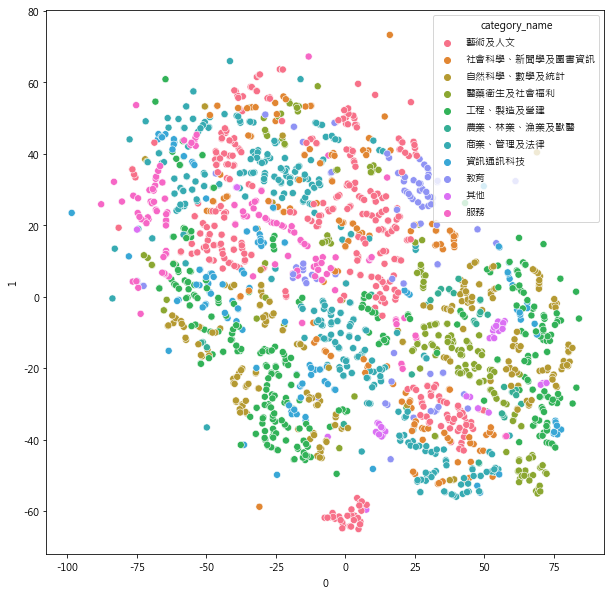

In [14]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=50)

jaccard的結果和cosine很像，但孤立的點相對多一點。（左上角）

#### Q2.6 (10%) 
Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. Your score depends on how useful, readable, and visually pleasing of your visualization results. 

* 本題選擇t-SNE cosine，因其聚集的狀況最不嚴重，每群的輪廓較明顯，且邊緣人較t-SNE jaccard來的少。

In [7]:
from sklearn.manifold import TSNE

In [17]:
X_embedded = TSNE(n_components=2, metric='cosine', random_state=0).fit_transform(dep_stu2)

dep_stu_pca=pd.DataFrame(X_embedded)
dep_stu_pca=pd.concat([dep_stu_pca, colname_df[['depname', 'category_name']]], axis=1)

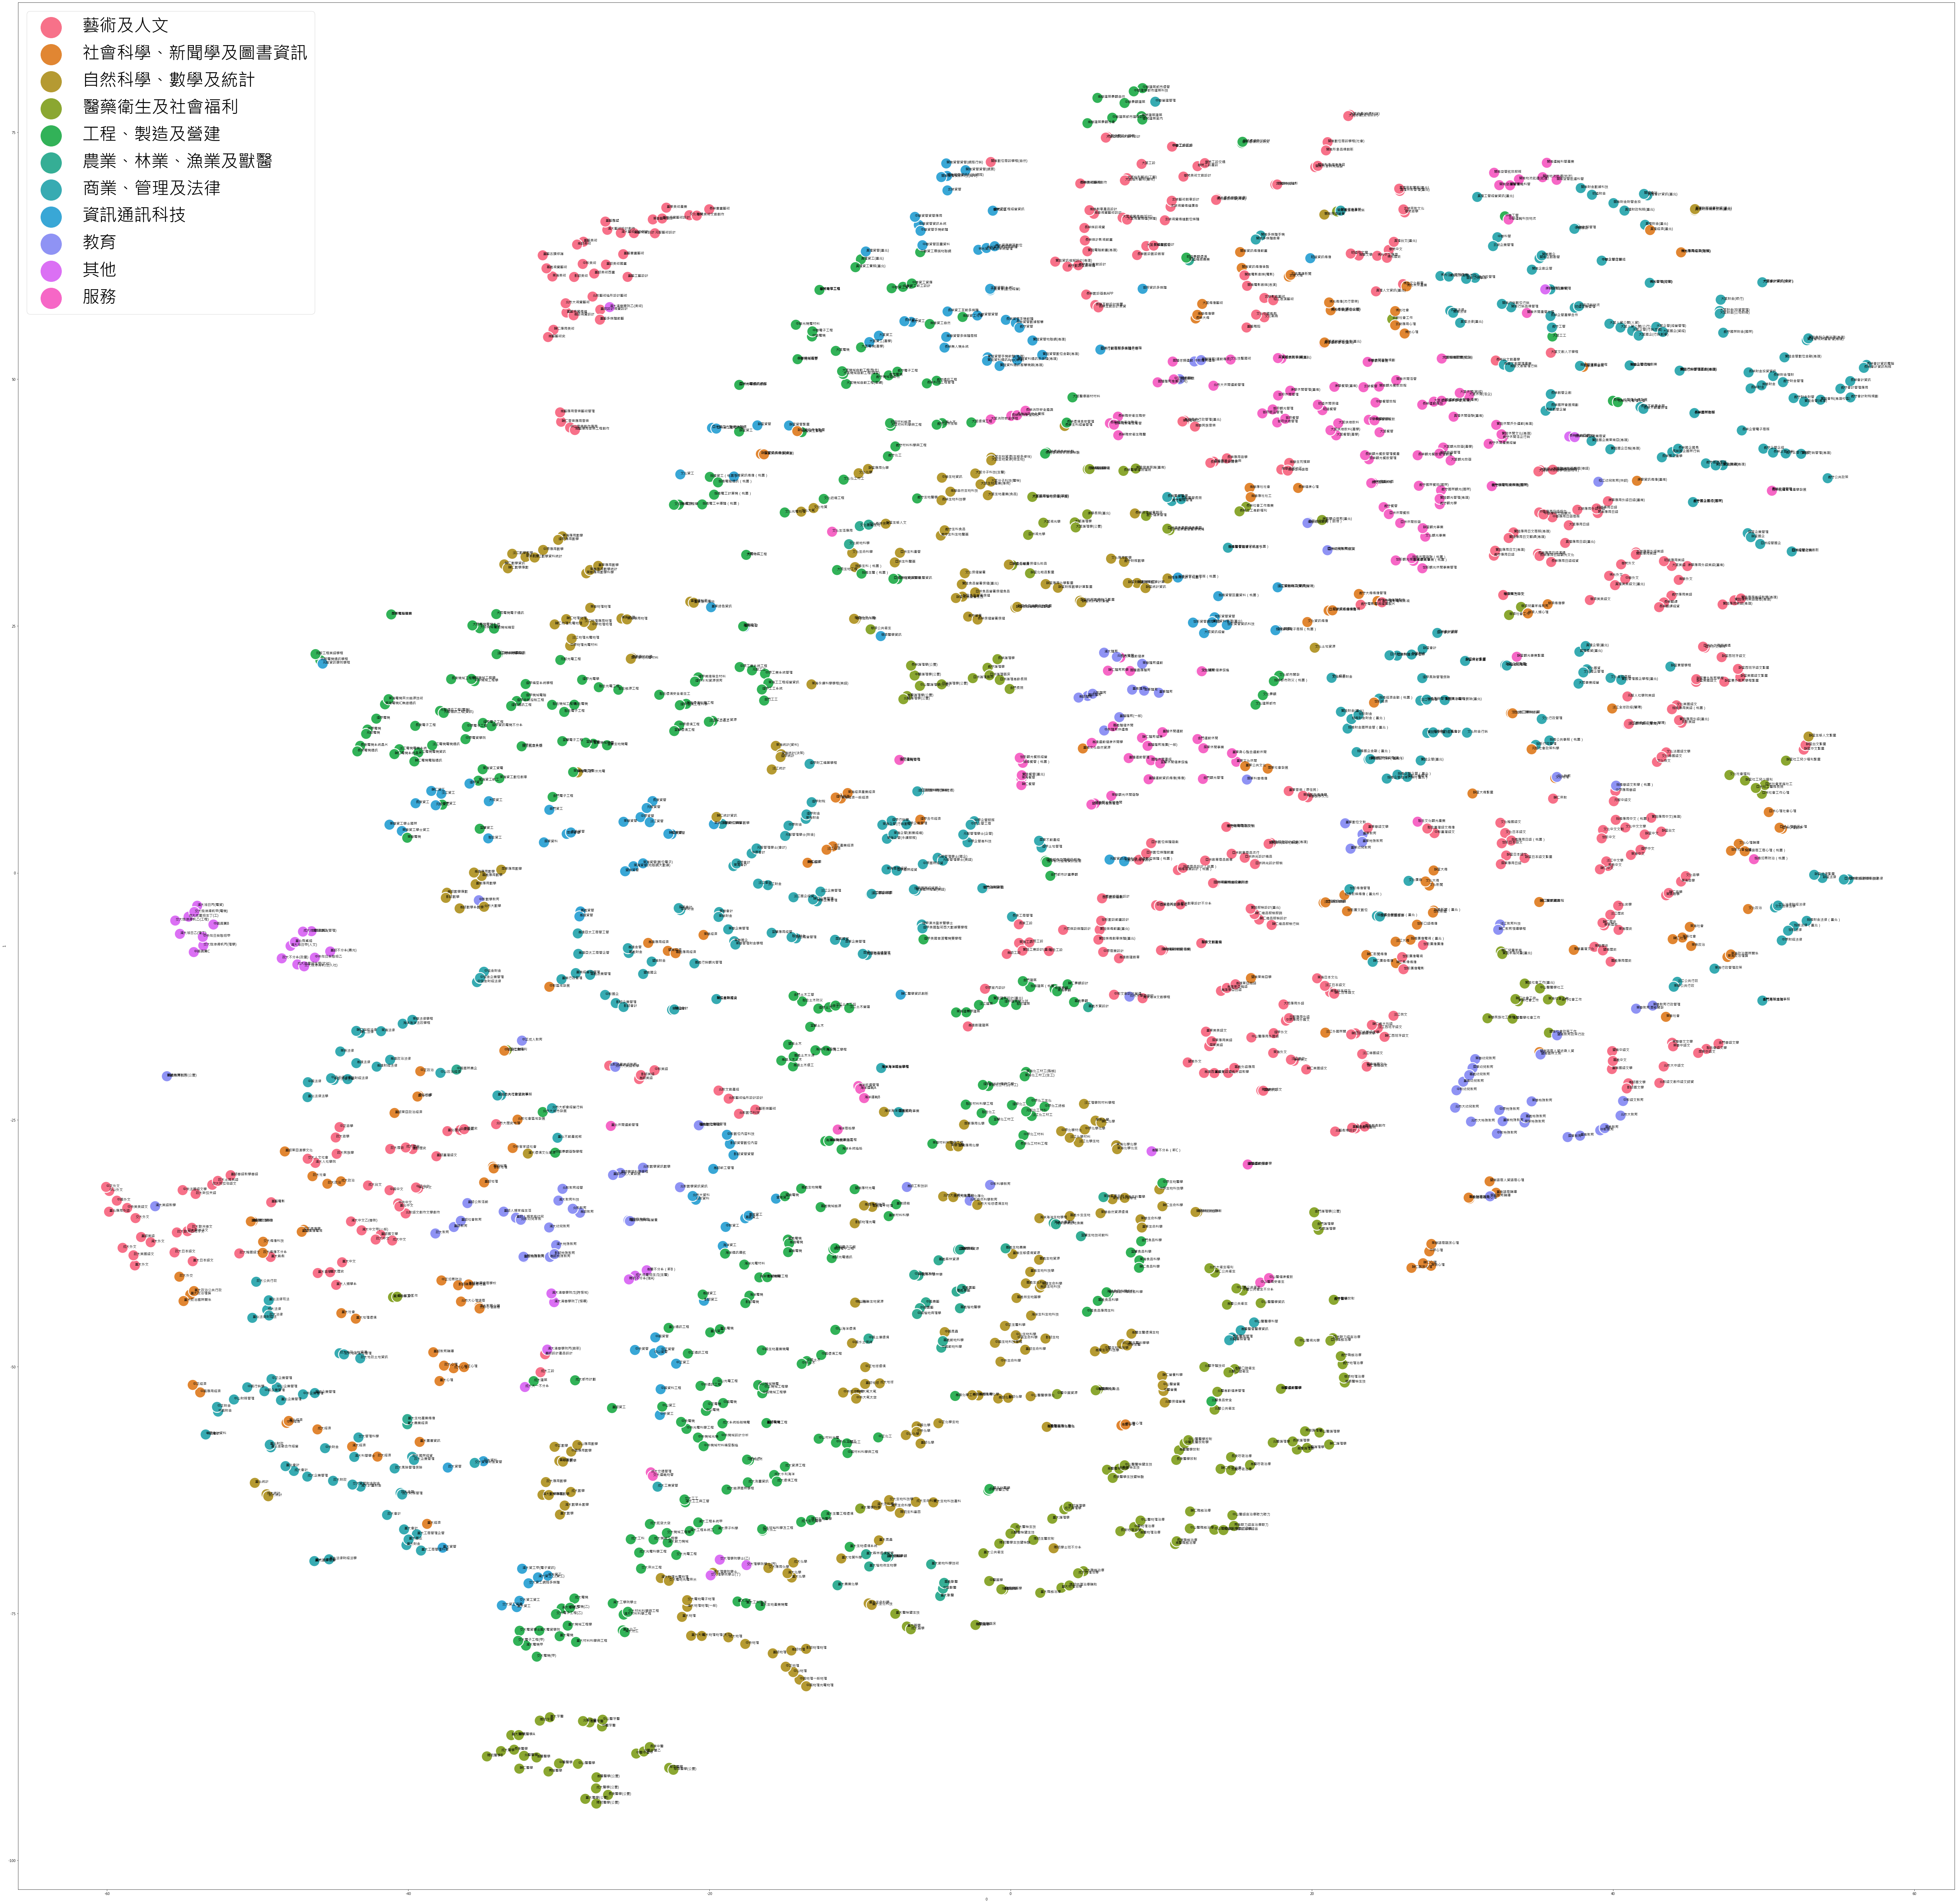

In [19]:
fig = plt.figure(figsize=(100, 100))
ax = sns.scatterplot(x=dep_stu_pca[0], y=dep_stu_pca[1], data=dep_stu_pca, hue='category_name', s=1000)
for i, txt in enumerate(dep_stu_pca['depname']):
    ax.annotate(txt, (dep_stu_pca[0][i], dep_stu_pca[1][i]))
plt.legend(loc='best', prop={'size': 50},markerscale=10)

In [ ]:
fig.savefig("t-SNE_cosine.png", format="png")

放大以後有些有趣的觀察，
* 接近等級學校的類似科系會很接近。（導致同學群不會在一起的主因，推測是因為考生不願意往下填太多）→選系不選絕對校，接受一個區間。Ex.「台政清交成」，「中字輩」...etc
* 商管和經濟不同學群但很接近（左下藍綠），電機和資工不同學群但很接近（下方藍and綠）→選校不選絕對系，接受類似系所
* 資管介於資工和商管的中間，符合科系定位
* 醫學系是最下面的淺綠→我一定要讀醫學系（沒有國防醫）
* 錄取門檻分布上呈現下方外緣門檻高，往上門檻低的趨勢。